# Fraud Detection
This is a project that will help a financial company in detecting fraudulent transactions
<br>Credits to this dataset https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

Data Dictionary:
- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - new balance after the transaction
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Inspiration
Following tasks & questions can be answered using the data,

1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

## Import relevant libraries and data

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import textwrap #for text wrapping in visualization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# For showing Progress Bar
from tqdm.notebook import tqdm

# Models
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

In [2]:
#pip install catboost

In [3]:
df_transactions = pd.read_csv("C:/Users/Shai/OneDrive/Documents/Data science/Finance and Acctg related projects/fraud.csv")

In [4]:
df_transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df_transactions.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df_transactions.shape

(6362620, 11)

The next codes provides an overview for each of the columns

In [8]:
#Added an hour of day column (0 to 23) derived from step
df_transactions['hour_of_day'] = (df_transactions['step'] - 1) % 24
df_transactions['hour_of_day'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: hour_of_day, dtype: int64

In [9]:
#Added an day of the week column (1 to 7) derived from step
df_transactions['day_of_the_week'] = df_transactions['step'] % 7
df_transactions['day_of_the_week'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: day_of_the_week, dtype: int64

In [10]:
df_transactions['type'].value_counts(normalize=True).round(2)

CASH_OUT    0.35
PAYMENT     0.34
CASH_IN     0.22
TRANSFER    0.08
DEBIT       0.01
Name: type, dtype: float64

In [11]:
df_transactions['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
df_transactions['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [13]:
#No null values upon checking
df_transactions.isnull().sum()

step               0
type               0
amount             0
nameOrig           0
oldbalanceOrg      0
newbalanceOrig     0
nameDest           0
oldbalanceDest     0
newbalanceDest     0
isFraud            0
isFlaggedFraud     0
hour_of_day        0
day_of_the_week    0
dtype: int64

In [14]:
# Create separate dfs for fraudulent tranx and flagged fraudulent tranx
df_fraud = df_transactions[df_transactions['isFraud'] == 1]
df_flagged_fraud = df_transactions[df_transactions['isFlaggedFraud'] == 1]

## EDA

### All df 

Text(0.5, 0, 'Hour of Day')

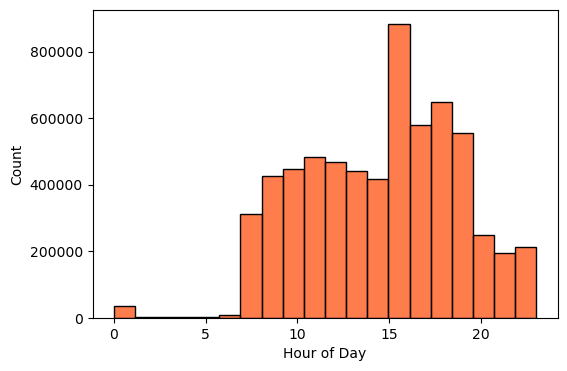

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df_transactions, x='hour_of_day',bins=20,alpha=0.7, color='#FF4500')
ax.set_xlabel("Hour of Day")

Text(0.5, 0, 'Day of the Week')

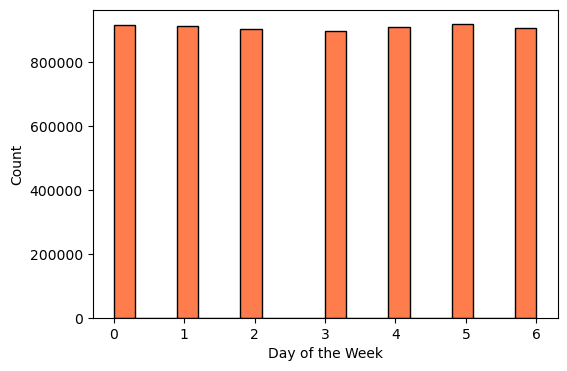

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df_transactions, x='day_of_the_week',bins=20,alpha=0.7, color='#FF4500')
ax.set_xlabel("Day of the Week")

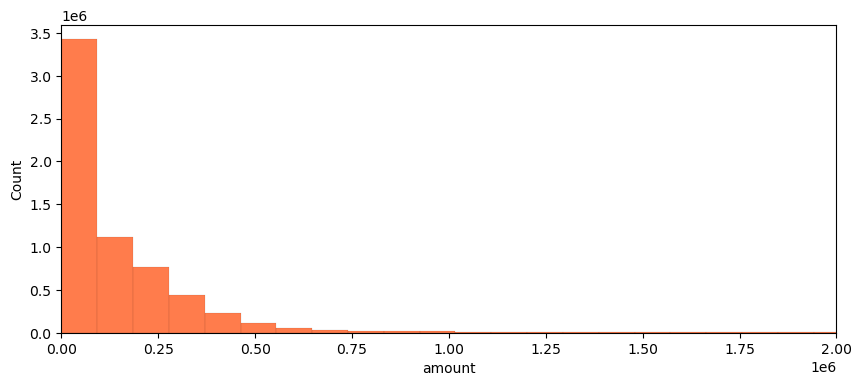

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_transactions, x='amount',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("amount")
plt.xlim(0, 2000000)
plt.show()

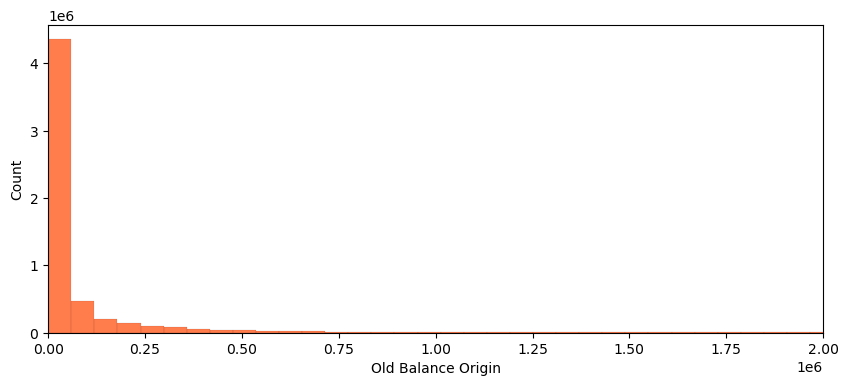

In [18]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_transactions, x='oldbalanceOrg',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("Old Balance Origin")
plt.xlim(0, 2000000)
plt.show()

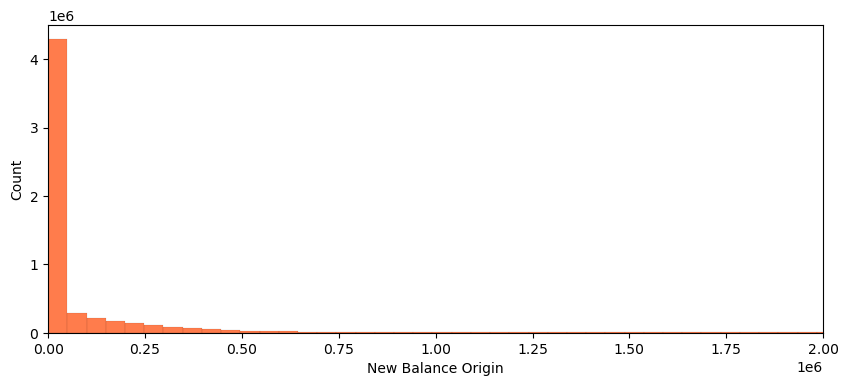

In [19]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_transactions, x='newbalanceOrig',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("New Balance Origin")
plt.xlim(0, 2000000)
plt.show()

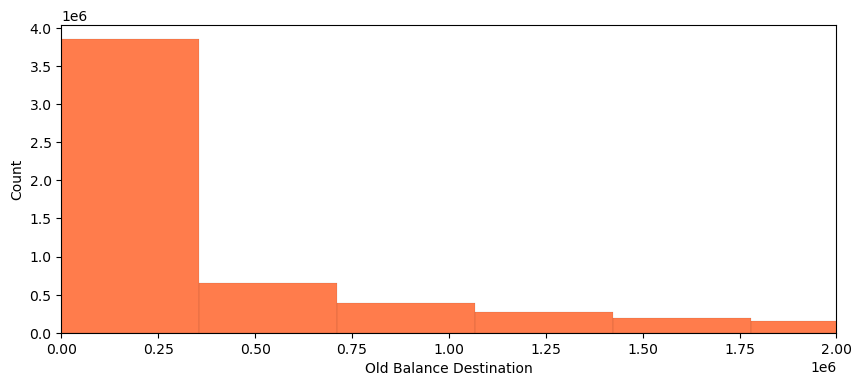

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_transactions, x='oldbalanceDest',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("Old Balance Destination")
plt.xlim(0, 2000000)
plt.show()

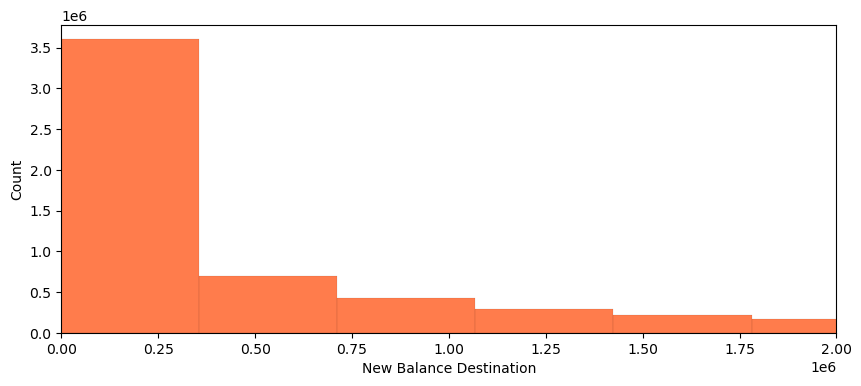

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_transactions, x='newbalanceDest',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("New Balance Destination")
plt.xlim(0, 2000000)
plt.show()

Text(0.5, 0, 'oldbalanceOrg')

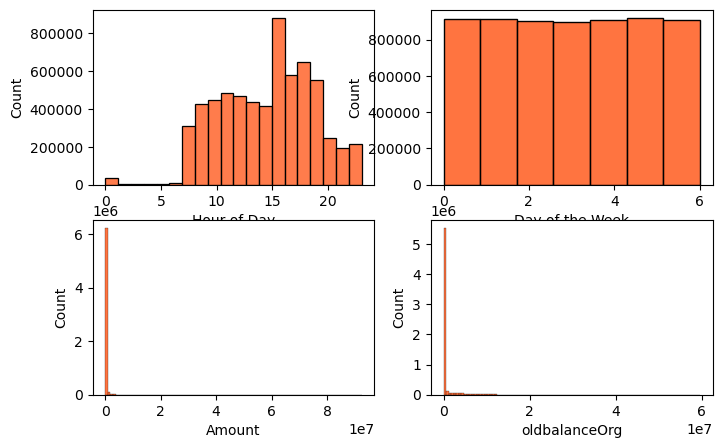

In [22]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
sns.histplot(data=df_transactions, x='hour_of_day',bins=20,alpha=0.7, color='#FF4500', ax = ax[0,0])
sns.histplot(data=df_transactions, x='day_of_the_week',bins=7, color='#FF4500', ax = ax[0,1])
sns.histplot(data=df_transactions, x='amount',bins=100, color='#FF4500', ax = ax[1,0])
sns.histplot(data=df_transactions, x='oldbalanceOrg',bins=100, color='#FF4500', ax = ax[1,1])
ax[0,0].set_xlabel("Hour of Day")
ax[0,1].set_xlabel("Day of the Week")
ax[1,0].set_xlabel("Amount")
ax[1,1].set_xlabel("oldbalanceOrg")

C:\Users\Shai\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


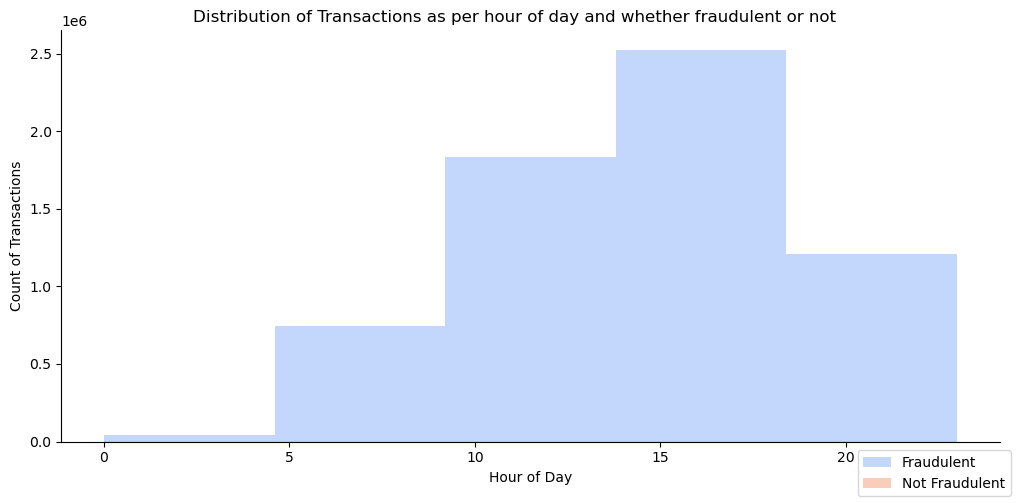

In [23]:
#Based on below fraudulent transactions are not noticeable in the next lines will just check the separate dfs
g = sns.FacetGrid(df_transactions,hue="isFraud",palette='coolwarm',size=5, aspect=2)
g = g.map(plt.hist,'hour_of_day',bins=5,alpha=0.7)
g.fig.suptitle("Distribution of Transactions as per hour of day and whether fraudulent or not")
g.set_axis_labels("Hour of Day", "Count of Transactions")
handles, labels = g.axes[0][0].get_legend_handles_labels()
g.fig.legend(handles, ["Fraudulent", "Not Fraudulent"], loc='lower right')

## Fraud df EDA

In [24]:
df_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_the_week
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0,1
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,0,1
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,0,1


Will replicate the same codes above for the df_fraud dataframe

In [25]:
df_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_the_week
count,8213.000000,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8213.0,8213.000000,8213.000000,8213.000000
mean,368.413856,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06,1.0,0.001948,11.423110,3.032266
std,216.388690,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06,0.0,0.044097,6.876553,1.979081
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,0.000000,0.000000
25%,181.000000,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,5.000000,1.000000
50%,367.000000,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03,1.0,0.000000,11.000000,3.000000
75%,558.000000,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06,1.0,0.000000,17.000000,5.000000
max,743.000000,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.0,1.000000,23.000000,6.000000


In [26]:
df_fraud['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

Text(0.5, 0, 'Hour of Day')

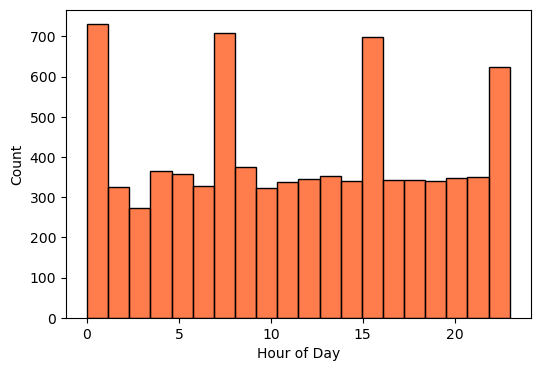

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df_fraud, x='hour_of_day',bins=20,alpha=0.7, color='#FF4500')
ax.set_xlabel("Hour of Day")

Text(0.5, 0, 'Day of the Week')

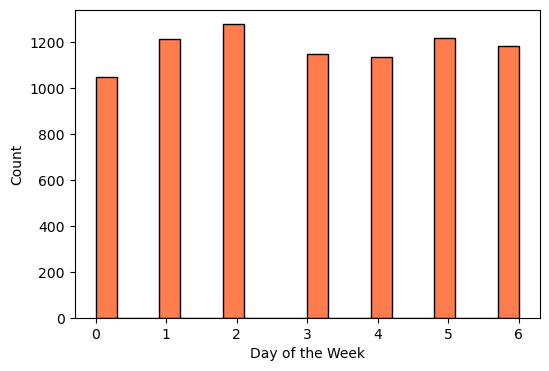

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df_fraud, x='day_of_the_week',bins=20,alpha=0.7, color='#FF4500')
ax.set_xlabel("Day of the Week")

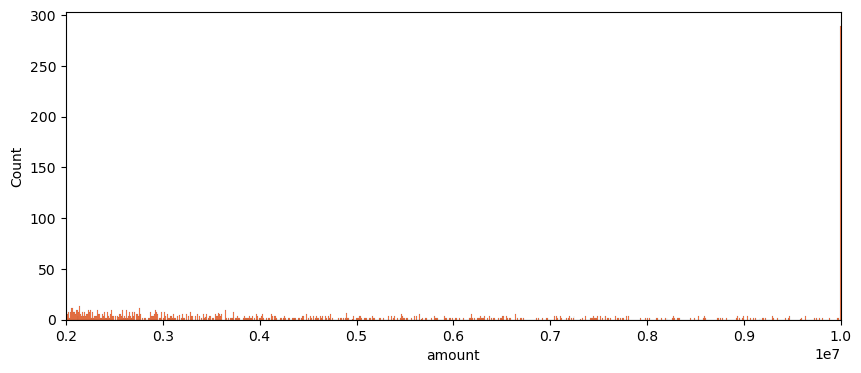

In [29]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_fraud, x='amount',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("amount")
plt.xlim(2000000, 10000000)
plt.show()

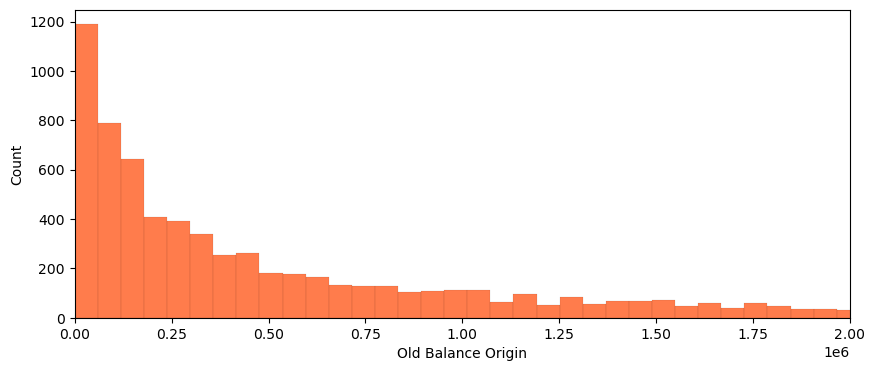

In [30]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_fraud, x='oldbalanceOrg',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("Old Balance Origin")
plt.xlim(0, 2000000)
plt.show()

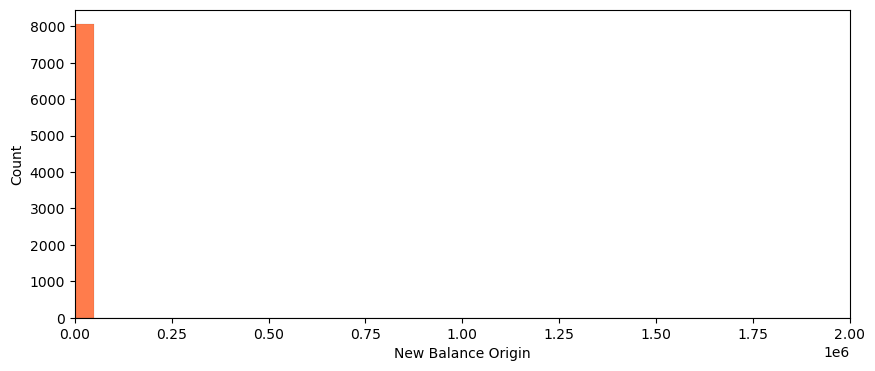

In [31]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_fraud, x='newbalanceOrig',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("New Balance Origin")
plt.xlim(0, 2000000)
plt.show()

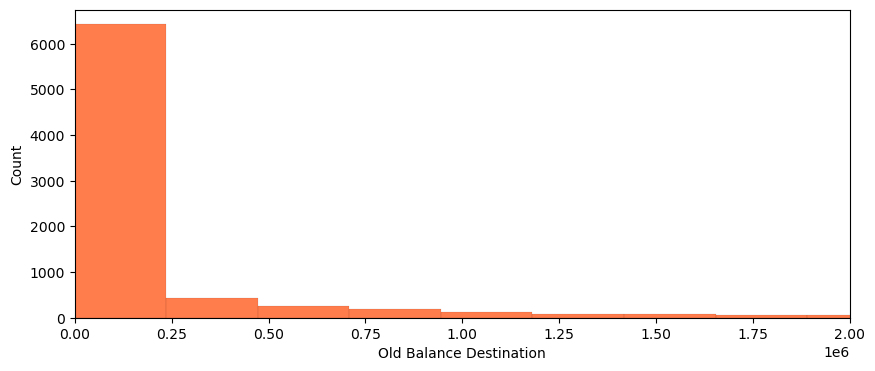

In [32]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_fraud, x='oldbalanceDest',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("Old Balance Destination")
plt.xlim(0, 2000000)
plt.show()

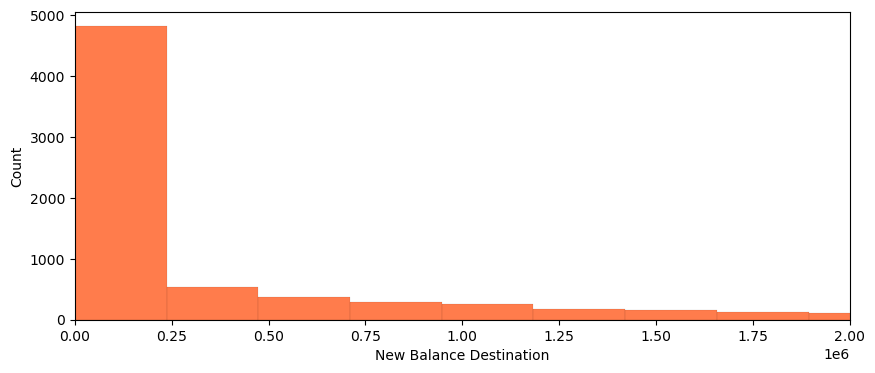

In [33]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_fraud, x='newbalanceDest',bins=1000,alpha=0.7, color='#FF4500')
ax.set_xlabel("New Balance Destination")
plt.xlim(0, 2000000)
plt.show()

Will create categories for the amount and balances

In [34]:
# Define percentiles
percentiles = np.array([0, 20, 40, 60, 80, 100])

# Create a new column 'amount_category' based on percentiles
df_transactions['amount_category'] = pd.cut(df_transactions['amount'], bins=pd.Series(df_transactions['amount']).quantile(percentiles/100), include_lowest=True, labels=[f"{p}th" for p in percentiles[1:]])


In [35]:
sorted_amounts = np.sort(df_transactions['oldbalanceOrg'].unique())

# Define percentiles
percentiles = np.array([0, 20, 40, 60, 80, 100])

# Create a new column 'amount_category' based on percentiles
df_transactions['old_balance_orig_category'] = pd.cut(df_transactions['oldbalanceOrg'], bins=np.percentile(sorted_amounts, percentiles), include_lowest=True, labels=[f"{p}th" for p in percentiles[1:]])

In [36]:
sorted_amounts = np.sort(df_transactions['newbalanceDest'].unique())

# Define percentiles
percentiles = np.array([0, 20, 40, 60, 80, 100])

# Create a new column 'amount_category' based on percentiles
df_transactions['new_balance_dest_category'] = pd.cut(df_transactions['newbalanceDest'], bins=np.percentile(sorted_amounts, percentiles), include_lowest=True, labels=[f"{p}th" for p in percentiles[1:]])

In [37]:
df_transactions['new_balance_dest_category'].head()

0    20th
1    20th
2    20th
3    20th
4    20th
Name: new_balance_dest_category, dtype: category
Categories (5, object): ['20th' < '40th' < '60th' < '80th' < '100th']

C:\Users\Shai\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


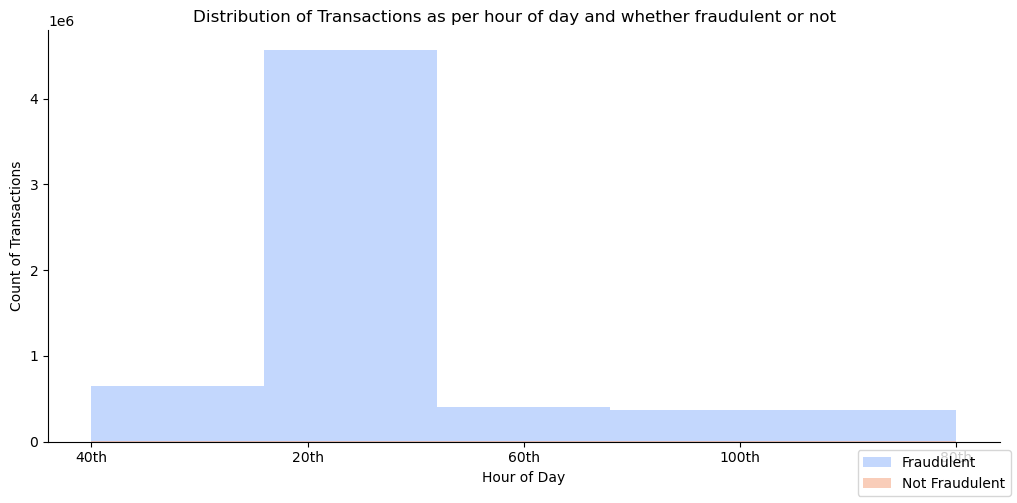

In [38]:
g = sns.FacetGrid(df_transactions,hue="isFraud",palette='coolwarm',size=5, aspect=2)
g = g.map(plt.hist,'old_balance_orig_category',bins=5,alpha=0.7)
g.fig.suptitle("Distribution of Transactions as per hour of day and whether fraudulent or not")
g.set_axis_labels("Hour of Day", "Count of Transactions")
handles, labels = g.axes[0][0].get_legend_handles_labels()
g.fig.legend(handles, ["Fraudulent", "Not Fraudulent"], loc='lower right')

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

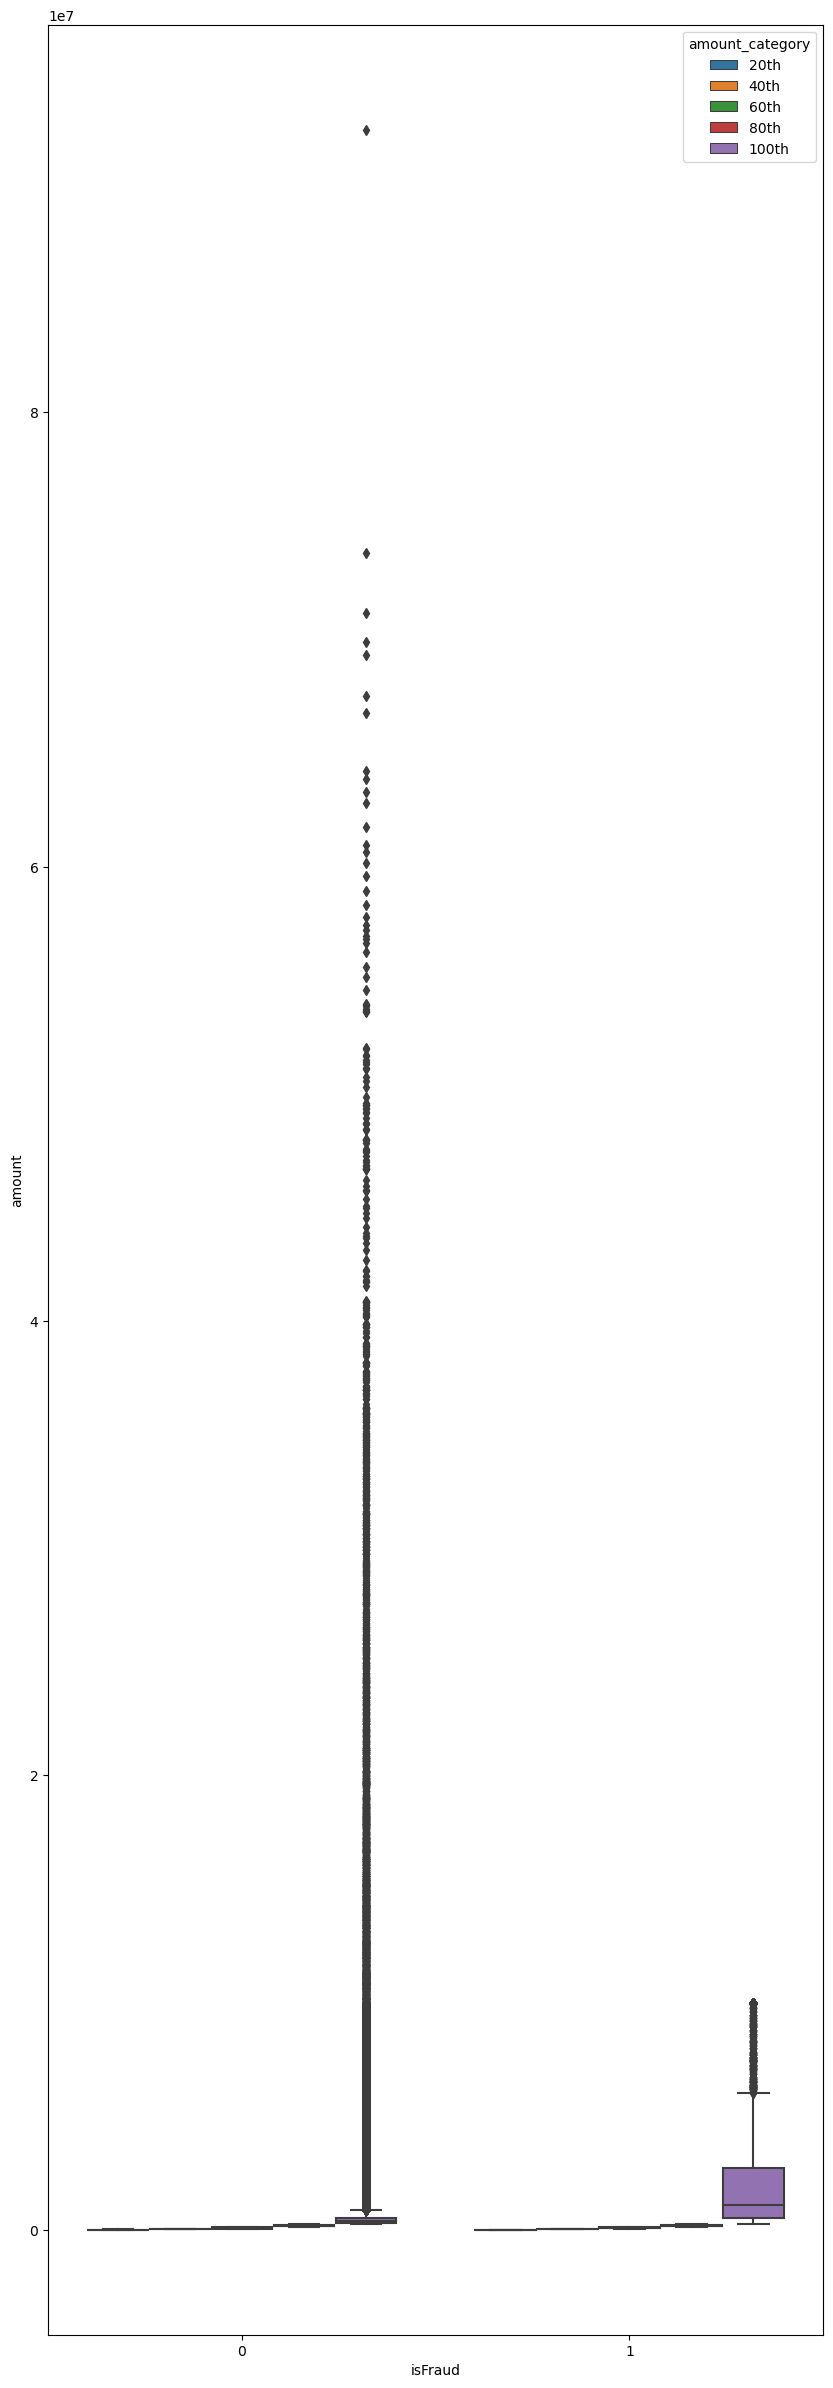

In [39]:
plt.subplots(figsize=(10,30))
sns.boxplot(data=df_transactions, x='isFraud', y='amount', hue='amount_category')

In [40]:
#use time density plot

NameError: name 'data_df' is not defined

## Modeling

In [42]:
types = pd.get_dummies(df_transactions['type'], prefix='type', drop_first=True)
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


In [43]:
df_transactions = pd.concat([df_transactions, types], axis=1)
df_transactions = df_transactions.drop(['step','type', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'amount_category', 'old_balance_orig_category', 'new_balance_dest_category'], axis=1)
df_transactions.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day_of_the_week,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,1,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,0,1,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,1,0


In [44]:
X = df_transactions.drop('isFraud', axis=1)
y = df_transactions['isFraud']

In [45]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [51]:
N_SPLITS = 2  # previous:300, increasing N_SPLITS to remove error due to randomness

lgbm_preds = []
xgb_preds = []
catb_preds = []

prob = []

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):

    print(f'fold {fold + 1}')

X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]

lgbm_model = lgbm.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Calculate training accuracy
training_accuracy = lgbm_model.score(X_train, y_train)
print(f'Training Accuracy: {training_accuracy}%')

# Generate class predictions for the test set
y_pred = lgbm_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy * 100}%')

  0%|          | 0/2 [00:00<?, ?it/s]

fold 1
fold 2
[LightGBM] [Info] Number of positive: 3303, number of negative: 2541745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 2545048, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001298 -> initscore=-6.645775
[LightGBM] [Info] Start training from score -6.645775
Training Accuracy: 0.9979748908468524
Test Accuracy: 99.7885305110159%


In [53]:
N_SPLITS = 2  # previous:300, increasing N_SPLITS to remove error due to randomness

lgbm_preds = []
xgb_preds = []
catb_preds = []

prob = []

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):

    print(f'fold {fold + 1}')

X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]

xgb_model  = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Calculate training accuracy
training_accuracy = xgb_model.score(X_train, y_train)
print(f'Training Accuracy: {training_accuracy}%')

# Generate class predictions for the test set
y_pred = xgb_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy * 100}%')

  0%|          | 0/2 [00:00<?, ?it/s]

fold 1
fold 2
Training Accuracy: 0.9998408674413999
Test Accuracy: 99.97673914205154%


In [48]:
# sample code that looped

N_SPLITS = 2  # previous:300, increasing N_SPLITS to remove error due to randomness

lgbm_preds = []
xgb_preds = []
catb_preds = []

prob = []

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):

    print(f'fold {fold + 1}')

    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]
    
    lgbm_model = lgbm.LGBMClassifier()
    xgb_model  = xgb.XGBClassifier()
    catb_model = catb.CatBoostClassifier(verbose=0)
    
    lgbm_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    catb_model.fit(X_train, y_train)
        
    print(f'Training Accuracy   :- {(lgbm_model.score(X_train, y_train)*100).round(2)}% | {(xgb_model.score(X_train, y_train)*100).round(2)}% | {(catb_model.score(X_train, y_train)*100).round(2)}%')
    print(f'Validation Accuracy :- {(lgbm_model.score(X_valid, y_valid)*100).round(2)}% | {(xgb_model.score(X_valid, y_valid)*100).round(2)}% | {(catb_model.score(X_valid, y_valid)*100).round(2)}%')
    
    prob1, prob2, prob3 = lgbm_model.predict_proba(X_test), xgb_model.predict_proba(X_test), catb_model.predict_proba(X_test)
    prob.append((prob1 + prob2 + prob3) / 3)
print('Model Trained !!!')

  0%|          | 0/2 [00:00<?, ?it/s]

fold 1
[LightGBM] [Info] Number of positive: 3303, number of negative: 2541745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 2545048, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001298 -> initscore=-6.645775
[LightGBM] [Info] Start training from score -6.645775


KeyboardInterrupt: 

In [ ]:
final = [[0,0]]
for i in range(N_SPLITS):
    final = final + prob[i]
    
final = final/N_SPLITS
y_pred = pd.Series([np.argmax([i]) for i in final])

In [ ]:
my_print(f'Test Accuracy:- {accuracy_score(y_test, y_pred)*100}%')

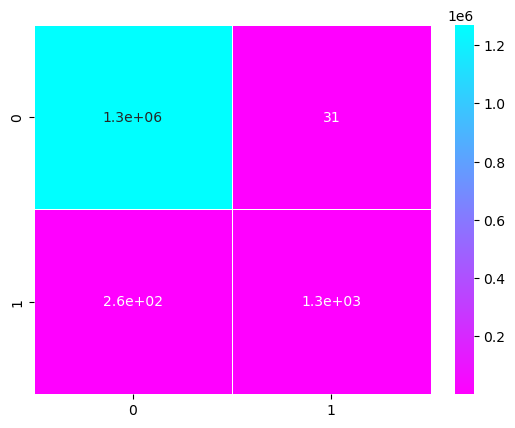

In [54]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='cool_r', linewidths=0.5, annot=True);